In [442]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import investpy
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Download stock data
I use data from Yahoo finance for the US stock market to select 50 stocks.

In [443]:
all_stocks = investpy.get_stocks_list(country='United States')
print('There are {} stocks'.format(str(len(all_stocks))))
stocks_selected = all_stocks[:50]
print('out of which '+  str(len(stocks_selected)) + ' are chosen')

There are 4582 stocks
out of which 50 are chosen


In [444]:
data = yf.download(stocks_selected, start = "2010-01-02", end = "2020-09-05")

[*********************100%***********************]  50 of 50 completed


In the paper, authors drop all assets that contain at least 1 non-traded day (NaN). But if  this is done here, no stocks would be left at all, so I drop those that have NaNs for more than 5% of asset history. I replace NaNs by zero to avoid computational problems.

In [445]:
close = data[['Adj Close']].dropna(axis = 1, how = 'all', thresh = data.shape[0] * 0.95) #drop stock if 5% of days are absent
close = close.fillna(0)
close.columns = close.columns.droplevel(0)
close.index = pd.to_datetime(close.index)
close.index = close.index.to_period(freq='d')
print(str(close.shape[1]) + ' stocks left')

44 stocks left


In [446]:
close.head(3)

,AA,ADBE,ADSK,BA,BAC,C,CAKFF,CAT,CSCO,CTAS,...,MRK,MSFT,MSI,ODP,ORCL,PDLI,SHLDQ,T,TEVA,VRTX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,37.018944,37.090000,25.670000,43.441975,13.816905,30.533976,19.843622,42.634403,18.785395,22.366045,...,25.517866,24.168472,26.879293,57.066406,21.604193,3.653801,62.962120,15.742277,47.299187,44.240002
2010-01-05,35.862801,37.700001,25.280001,44.864773,14.266021,31.701447,19.843622,43.144135,18.701702,22.332144,...,25.621284,24.176279,26.508316,59.809143,21.578108,3.648489,65.815117,15.665167,46.629093,42.779999
2010-01-06,37.730419,37.619999,25.340000,46.225727,14.433337,32.689320,19.843622,43.275200,18.579962,22.391468,...,25.966017,24.027906,26.879293,58.482006,21.265123,3.606004,67.075569,15.435946,46.743496,42.029999


In this work, I will use both prices and returns. Returns will be used to cluster stocks, prices - to find cointegrated pairs.

In [447]:
returns = close.pct_change().iloc[1:, :]
returns = returns.replace([np.inf, -np.inf], np.nan)
returns = returns.dropna(axis = 0)
returns = returns.fillna(0)
returns.head(3)

,AA,ADBE,ADSK,BA,BAC,C,CAKFF,CAT,CSCO,CTAS,...,MRK,MSFT,MSI,ODP,ORCL,PDLI,SHLDQ,T,TEVA,VRTX
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.031231,0.016446,-0.015193,0.032752,0.032505,0.038235,0.0,0.011956,-0.004455,-0.001516,...,0.004053,0.000323,-0.013802,0.048062,-0.001207,-0.001454,0.045313,-0.004898,-0.014167,-0.033002
2010-01-06,0.052077,-0.002122,0.002373,0.030335,0.011728,0.031162,0.0,0.003038,-0.006510,0.002656,...,0.013455,-0.006137,0.013995,-0.022190,-0.014505,-0.011645,0.019151,-0.014633,0.002453,-0.017532
2010-01-07,-0.021214,-0.019405,0.005525,0.040482,0.032947,0.002747,0.0,0.004038,0.004505,0.008706,...,0.001594,-0.010400,0.020075,0.055976,-0.003271,0.002945,0.116012,-0.011228,-0.006294,-0.012610


### Filtering
First, data needs to be filtered. I use AR(1)-TGARCH(1,1) model for this. For now, I filter only training sets of prices and returns (dates 2010-01-04 - 2019-12-31). I filter data in windows of size 100 (although not sliding window, since it would be too long). So first 100 days are filtered, than days from 200 to 300 and so on.

In [448]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model 
from arch.univariate import ARX, GARCH, StudentsT

In [560]:
filt_ret_f = returns.loc[:'2019-01-01', :]
price_train_f = close.loc[:'2019-01-01', :]

In [450]:
def filter_train_set(filt_ret, window):
    """filter training dataset with AR(1)-TGARCH(1,1)"""
    all_ret = np.full((filt_ret.shape[0] - 1, filt_ret.shape[1]), 0, dtype = 'float64')
    for col in range(filt_ret.shape[1]):
        start = 0
        end = start + window
        while end < all_ret.shape[0]-1:
        
            try:
                order = 10 / filt_ret.iloc[start:end, col].std()
            except ZeroDivisionError:
                order = 10
            mod = arch_model(order * filt_ret.iloc[start:end, col],
                            mean='ARX', lags=1, 
                            vol='Garch', p=1, o=1, q=1, 
                            dist='skewstudent')
            try:
                mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
                all_ret[start:end -1, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
            except: #can be that in this range all values are zero, which throws a mistake
                all_ret[start:end -1, col] = filt_ret.iloc[start:end - 1, col]
            start = end 
            end += window

        end -= 100   

        try:
            order = 10 / filt_ret.iloc[end:, col].std()
        except ZeroDivisionError:
            order = 10
        mod = arch_model(order * filt_ret.iloc[end: , col],
                        mean='ARX', lags=1, 
                        vol='Garch', p=1, o=1, q=1, 
                        dist='skewstudent') 
        try:
            mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
            all_ret[end:, col] = mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] 
        except: #can be that in this range all values are zero, which throws a mistake
            all_ret[end :, col] = filt_ret.iloc[end: - 1, col]
    filt_ret = pd.DataFrame(all_ret, index = filt_ret.index[1:], columns = filt_ret.columns, dtype = 'float64')
    return filt_ret

In [451]:
filt_ret = filter_train_set(filt_ret_f, 100)
price_train = filter_train_set(price_train_f, 100)

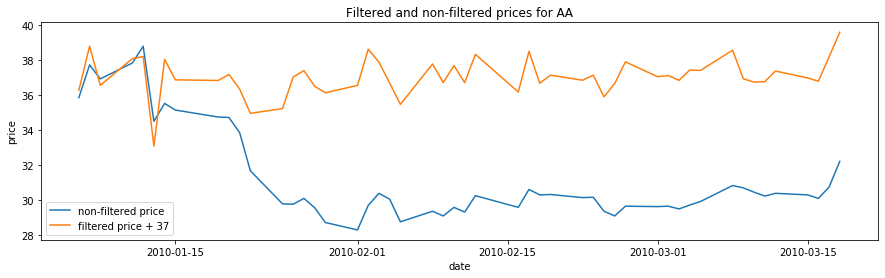

In [569]:
plt.figure(figsize = (15,4))
plt.plot(returns.index.to_timestamp()[1:51], close.iloc[1:51, 0], label = 'non-filtered price');
plt.plot(returns.index.to_timestamp()[1:51], price_train.iloc[:50, 0] + 37, label = 'filtered price + 37');
plt.title('Filtered and non-filtered prices for {}'.format(price_train.columns[0]))
plt.legend()
plt.xlabel('date')
plt.ylabel('price');

I also split unfiltered prices in train/test datasets and dataset on which profitability will be measured. The dates are:
- 2010-01-04 - 2018-12-31 training dataset
- 2019-01-01 - 2019-12-31 test dataset
- 2020-01-01 - 2020-09-04 dataset for profitability measurement

In [455]:
raw_price_train = close.loc[:'2019-01-01', :]
raw_price_val = close.loc['2019-01-01':'2020-01-01']
raw_price_test = close.loc['2020-01-01':]

### PCA dimensionality reduction and OPTICS clustering
First, I cluster filtered returns to find classes of similar stocks. Later, I will find cointegrated pairs inside each cluster.
To do this, first I turn the history of each stock into lower dimension with Principal Component Analysis (PCA).The authors set upper bound at 15 principal components to avoid curse of dimensionality, and I do so as well. 
Then, these components serve as input to OPTICS - ordering points to identify the clustering structure algorithm. This is density based clustering algorithm which automaticlly finds the number of clusters. For it I need to specify number of points to form a cluster. I range number of samples from 2 to 6. 
To choose among models, for each number of principal components I fit OPTICS across all range of samples. Then I use silhouette score to determine the best model. It is in range between -1 and 1, the higher it is the better.

In [456]:
def find_max(silhouette):
    all_vals = []
    for val in silhouette.values():
        all_vals.extend(val)
    return all_vals

def best_params(silhouette):
    """find best model based on silhouette score"""
    all_vals = find_max(silhouette)
    max_val = max(all_vals)
    for key, val in silhouette.items():
        if max_val in val:
            return key, val.index(max_val) + 2, max_val

In [457]:
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

silhouette = dict()
for comp in range(2, 16):
    partial_silh = list()
    pca = PCA(n_components = comp, svd_solver = 'auto')
    pca_fit = pca.fit_transform(filt_ret.transpose())
    for min_sampl in range(2, 7):
        try:
            clusters = OPTICS(min_samples = min_sampl).fit(pca_fit) #metric = 'euclidean' min_cluster_size = 5
            partial_silh.append(silhouette_score(pca_fit, clusters.labels_))
        except: pass
    silhouette[comp] = partial_silh
    
best_comp, best_min_smpl, best_score = best_params(silhouette)
print('best silhouette_score is ' + str(best_score) + ' at ' + str(best_min_smpl) + ' min_samples and ' +
      str(best_comp) + ' components')

best silhouette_score is 0.42881716676959464 at 4 min_samples and 2 components


In [458]:
pca = PCA(n_components = best_comp, svd_solver = 'auto')
pca_fit = pca.fit_transform(filt_ret.transpose())
clusters = OPTICS(min_samples = best_min_smpl).fit(pca_fit)

Number of clusters is 5


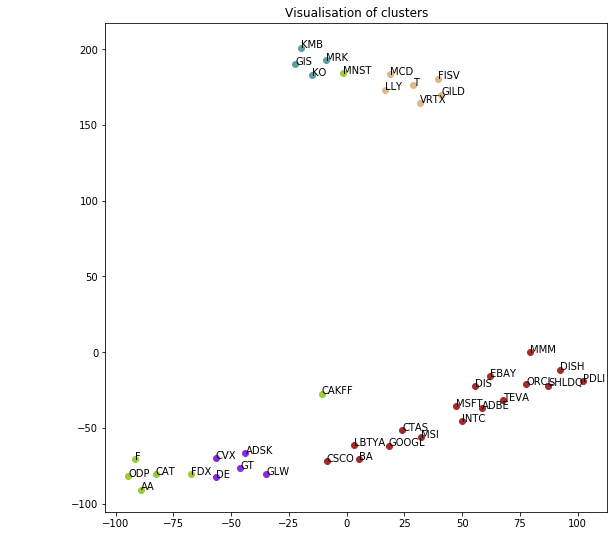

In [556]:
from sklearn.manifold import TSNE
import matplotlib.colors as mcolors

tsne = TSNE(n_components = 2, perplexity = 6).fit_transform(pca_fit)

print('Number of clusters is ' + str(clusters.labels_.max()-clusters.labels_.min()))
colors = list(mcolors.CSS4_COLORS.keys())[10:]
plt.figure(figsize=(9,9))
for klass in range(clusters.labels_.min(), clusters.labels_.max()):
    plt.scatter(tsne[clusters.labels_ == klass][:, 0], tsne[clusters.labels_ == klass][:, 1],
               c = colors[klass], label = 'class {}'.format(str(klass)))
for i, txt in enumerate(filt_ret.columns):
    plt.annotate(txt, (tsne[i, 0], tsne[i, 1]))
plt.title('Visualisation of clusters')
plt.savefig('clusters1.png');

I split training dataset on prices into several classes based on clusters. I drop class -1 since points belonging to it are outliers or points without cluster.

In [460]:
def make_classes(df):
    """divide data according to clusters"""
    classes = dict()
    for cl in range(0, clusters.labels_.max() + 1):
        klass = df.transpose()[clusters.labels_ == cl]
        classes[cl] = klass
    return classes

In [461]:
raw_classes = make_classes(raw_price_train)
filtered_classes = make_classes(price_train)

### Select pairs
Next, I select pairs based on the following criteria:
- presence of cointegration (to determine it I use augmented Engle-Granger two-step cointegration test)
- Hurst exponent < 0.5 for the series to be anti-persistent
- half life of mean reversion between a day and a year
- average number of crossings of spread mean per year is at least 12 (meaning at least 1 trade per month on average)

In [463]:
from statsmodels.tsa.stattools import coint
from hurst import compute_Hc
from scipy.ndimage.interpolation import shift
from sklearn import linear_model

In [464]:
def compose_pairs(classes):
    """check cointegration"""
    pairs = list()
    for cl in classes.keys():
        tested_pairs = list()
        for smpl in range(classes[cl].shape[0]):
            for smpl2 in range(classes[cl].shape[0]):
                if smpl != smpl2 and (smpl2, smpl) not in tested_pairs: #no cointegration with itself, check pair has not been tested
                    tested_pairs.append((smpl2, smpl))
                    cointegrated = coint(classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2, :], return_results = True)
                    if cointegrated[1] < 0.05: #pvalue
                        pairs.append([classes[cl].iloc[smpl, :], classes[cl].iloc[smpl2,:]])
    print('There are {} pairs at cointegration stage'.format(len(pairs)))
    return pairs

In [465]:

def calc_Hurst(pairs):
    """check spread mean-reversion"""
    for pair in pairs:
        spread = pair[0] - pair[1]
        H, c, data = compute_Hc(spread)
        if H >= 0.5: #Brownian motion or persistent
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at Hurst stage'.format(len(pairs)))
    return pairs

In [466]:


def calc_half_life(pairs):
    """check mean-reversion half life"""
    lin_reg = linear_model.LinearRegression()
    for pair in pairs:
        for ts_n, ts in enumerate(pair):
            ts_delta = ts - ts.shift()
            lin_reg.fit(np.array(ts.shift()[1:]).reshape(-1,1), np.array(ts_delta[1:]).reshape(-1,1)) 
            half_life = -np.log(2) / lin_reg.coef_.item()
            if half_life < 1 or half_life > 365:
                del pair[ts_n]
                pairs.remove(pair)
                break
    print('There are {} pairs at mean-reversion half life stage'.format(len(pairs)))
    return pairs

In [467]:

def number_mean_reversions(pairs):
    """check that on average there are at least 12 crossings of spread mean per year"""
    years_num  = len(price_train.index.to_timestamp().year.unique())
    for pair in pairs:
        spread = pair[0] - pair[1]
        crosses = 0
        for i in range(len(spread) - 1):
            if (spread[i] > spread.mean() and spread[i + 1] < spread.mean()) or (spread[i] < spread.mean() and spread[i + 1] > spread.mean()):
                crosses += 1
        if crosses < 12 * years_num:
            for ts in pair:
                pair.remove(ts)
            pairs.remove(pair)
    print('There are {} pairs at calculation of mean-reversions number stage'.format(len(pairs)))
    return pairs

In [468]:
print('For unfiltered prices:')
raw_pairs = compose_pairs(raw_classes)
raw_pairs = calc_Hurst(raw_pairs)
raw_pairs = calc_half_life(raw_pairs)
raw_pairs = number_mean_reversions(raw_pairs)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered prices:')
filt_pairs = compose_pairs(filtered_classes)
filt_pairs = calc_Hurst(filt_pairs)
filt_pairs = calc_half_life(filt_pairs)
filt_pairs = number_mean_reversions(filt_pairs)

For unfiltered prices:
There are 44 pairs at cointegration stage
There are 28 pairs at Hurst stage
There are 19 pairs at mean-reversion half life stage
There are 9 pairs at calculation of mean-reversions number stage
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered prices:
There are 354 pairs at cointegration stage
There are 311 pairs at Hurst stage
There are 156 pairs at mean-reversion half life stage
There are 112 pairs at calculation of mean-reversions number stage


### Selection of best pairs
In this part, I select best pairs for trade. On test dataset, I simulate trade with a given pair and record portfolio value, return, and capital invested on each day of trade. 

There are two options - we may filter test dataset or may not. Next, I calculate spread between prices of paired stocks (P1 - P2), make a predition for one day with ARMA(1,1) for the spread, and calculate spread expected percentage change. If it is larger than some threshold, I buy P1 and sell P2. If lower than some other threshold - I sell P1 and buy P2. Trade is done without leverage each time, and each trade is not more than 100 000$. Commission is set at 0.1 %.

The thresholds are determined individually for each pair. Spread is calculated for all history in training dataset, and distribution of its percentage change is obtained. From it, I select two sets of thresholds - 0.1 and 0.9 deciles, and 0.2 and 0.8 quantiles. With each set I simulate trade and obtain mean return of portfolio. Then I keep mean return and the threshold set that generated highest mean return.

In [471]:
def arma_garch(price):
    """AR(1)-TGARCH(1,1) model for filtering"""
    order = 10 / price.std()
    mod = arch_model(order * price,
                    mean='ARX', lags=1, 
                    vol='Garch', p=1, o=1, q=1, 
                    dist='skewstudent')
    mod_fit = mod.fit(options = {'maxiter':500}, disp='off', show_warning = False)
    pred = mod_fit.forecast(horizon=1)
    return mod_fit.resid[1:] / mod_fit.conditional_volatility[1:] * price.std() / 10, float(pred.mean.iloc[-1])  * price.std() / 10, float(pred.variance.iloc[-1]) * price.std() / 10 
    #since previously we multiplied by 10 and divided by std
    
    def spread_change(spread):
    spread_chg = (spread.shift(-1) - spread)[:-1]
    spread_chg = spread_chg / spread[:-1]
    return spread_chg

In [484]:
def trade(a_sh, a_lo, window, account, next_df, previous_df, name1, name2, mode = 'none'):
    """ Simulation of trade with sliding window for 1 pair. Calculates returns, portfolio value, and invested capital for each day. 
    Insert only unfiltered previous_df and next_df, otherwise they will be filtered twice"""
    portfolio_value_list = []
    acc_return_list = []
    cap_invested = []
    commission = 0.001
    stock1 = 0
    stock2 = 0
    acc_return = 0.0
    prev_capital = 0.0
    prev_price1 = 0.0
    prev_price2 = 0.0
    prev_stock1 = 0
    prev_stock2 = 0
    start_idx = 0
    trade_indicator = 'no_trade'
    portfolio_value = 0
    end_idx = start_idx + window + 1 #last observation is not included
    resid = 0.0
    full_df = pd.concat([previous_df.iloc[-window:,:], next_df], axis = 0)
    while end_idx <= full_df.shape[0] - 1:
        p1 = full_df[name1][start_idx:end_idx]
        p2 = full_df[name2][start_idx:end_idx]
        if mode == 'filter':
            p1 = arma_garch(p1)[0]
            p2 = arma_garch(p2)[0]
        spread = p1 - p2
        try:
            arma = ARIMA(np.array(spread), order = (1,0,1)).fit()
            pred = arma.forecast(steps=1, exog=None, alpha=0.01)
            pred_chg = (pred - spread[-1:] / spread[-1:])[0]
        except: #may be LU decomposition error with filtered data
            arma = ARIMA(np.array(spread * 100), order = (1,0,1)).fit()
            pred = arma.forecast(steps=1, exog=None, alpha=0.01)/100
            pred_chg = (pred - spread[-1:] / spread[-1:])[0]
        
        price1 = p1[-1:][0]
        price2 = p2[-1:][0]
        
        portfolio_value = resid + stock1 * price1 + stock2 * price2 #portfolio revaluation 
        portfolio_value_list.append(portfolio_value)
        
        if price1 != 0 and price2 != 0: #if stock was traded
            if trade_indicator == 'short':
                acc_return += ((prev_price1 - price1)*prev_stock1 + (price2 - prev_price2)*prev_stock2) / prev_capital
            elif trade_indicator == 'long':
                acc_return += (prev_price2 - price2)*prev_stock2 + (price1 - prev_price1)*prev_price1 / prev_capital
            acc_return_list.append(acc_return)
            
            if pred_chg <= a_sh:
                trade_indicator = 'short'
                deal1 = stock1 * price1 * (1 - commission) #sell stock1
                if stock1 != 0:
                    prev_stock1 = stock1
                if deal1 > allocated_capital: 
                    stock1_to_sell = allocated_capital // (price1 * (1 - commission))
                    deal1 = stock1_to_sell * price1 * (1 - commission)
                    stock1 -= stock1_to_sell
                    if stock1_to_sell != 0:
                        prev_stock1 = stock1_to_sell
                else:
                    stock1 = 0
                account += deal1
                stock_2_bought = account // (price2 * (1 + commission))
                deal2 = stock_2_bought * price2 * (1 + commission) #buy stock2
                if deal2 > allocated_capital:
                    stock_2_bought = allocated_capital // (price2 * (1 + commission))
                    deal2 = stock_2_bought * price2 * (1 + commission)
                account -= deal2
                resid = account
                stock2 += stock_2_bought

                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_2_bought != 0:
                    prev_stock2 = stock_2_bought

            elif pred_chg >= a_lo:
                trade_indicator = 'long'
                deal2 = stock2 * price2 * (1 - commission) #sell stock2
                if stock2 != 0:
                    prev_stock2 = stock2
                if deal2 > allocated_capital:
                    stock2_to_sell = allocated_capital // (price2 * (1 - commission))
                    deal2 = stock2_to_sell * price2 * (1 - commission)
                    stock2 -= stock2_to_sell
                    if stock2_to_sell != 0:
                        prev_stock2 = stock2_to_sell
                else:
                    stock2 = 0
                account += deal2
                stock_1_bought = account // (price1 * (1 + commission))
                deal1 = stock_1_bought * price1 * (1 + commission) #buy stock1
                if deal1 > allocated_capital:
                    stock_1_bought = allocated_capital // (price1 * (1 + commission))
                    deal1 = stock_1_bought * price1 * (1 + commission)
                account -= deal1
                resid = account
                stock1 += stock_1_bought
                if deal1+deal2 != 0:
                    prev_capital = deal1+deal2
                    cap_invested.append(prev_capital)
                if stock_1_bought != 0:
                    prev_stock1 = stock_1_bought

            prev_price1 = price1
            prev_price2 = price2
            
        start_idx += 1
        end_idx += 1
        
    portfolio_value_list[0] = allocated_capital
    return acc_return_list, portfolio_value_list, cap_invested

def calc_returns(val_port_value, allocated_capital):
    """Calculates returns on capital invested"""
    total_returns = []
    for p in val_port_value:
            total_returns.append((p - allocated_capital) * 100 / allocated_capital)
            total_returns[0] = 0 #because at index 0 there has not been any return yet
    return total_returns 
    

In [473]:
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean

def find_thresholds(pairs,price_train,  price_val, prev_df, window, allocated_capital, mode = 'none'):
    """Calculates profitability of each pair and finds optimal thresholds. price_val and prev_df should be unfiltered"""
    chosen_params = []
    cv_profit = []

    for pair_num in range(len(pairs)):
        name1 = pairs[pair_num][0].name
        name2 = pairs[pair_num][1].name
        spread = price_train.loc[:, name1] - price_train.loc[:, name2]
        spread_chg = spread_change(spread)
        quantiles = np.quantile(spread_chg, [0.2, 0.8], interpolation = 'linear')
        deciles = np.quantile(spread_chg, [0.1, 0.9], interpolation = 'linear')

        cv_thresh_res = []
        for thresh in [quantiles, deciles]:
            val_returns, val_port_value, cap_inv = trade(thresh[0], thresh[1], window, allocated_capital,  price_val, prev_df, name1, name2, mode) 
            total_returns = calc_returns(val_port_value, allocated_capital)
            cv_thresh_res.append(mean(total_returns)) #not sum but mean
            
        best_thresh = cv_thresh_res.index(max(cv_thresh_res))
        if best_thresh == 0:
            chosen_params.append(pd.Series(quantiles,name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        else:
            chosen_params.append(pd.Series(deciles, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
        max_profit =  max(cv_thresh_res)
        cv_profit.append(pd.Series(max_profit, name = pairs[pair_num][0].name + '-' + pairs[pair_num][1].name))
    return cv_profit, chosen_params

I simulate trade for 3 datasets. First one uses unfiltered prices to trade pairs found on unfiltered data. Second one uses filtered prices to trade pairs found on filtered data. Last one uses unfiltered prices to trade pairs found on filtered data.

In [813]:
allocated_capital = 100000 
raw_cv_profit, raw_chosen_params = find_thresholds(raw_pairs, raw_price_train, raw_price_val, raw_price_train, 200, allocated_capital)

The computations for filtered pairs would be too long, so I sample 14 of them randomly.

In [614]:
import random
random_pairs = []
for ii in range(15):
    random_pairs.append(random.choice(filt_pairs))

In [494]:
filt_cv_profit, filt_chosen_params = find_thresholds(random_pairs, price_train, raw_price_val, raw_price_train, 200, allocated_capital, 'filter')

In [812]:
mixed_cv_profit, mixed_chosen_params = find_thresholds(random_pairs, raw_price_train, raw_price_val, raw_price_train, 200, allocated_capital)

Then I keep only profitable pairs. I sort them based on their mean return and select 5 best pairs.

In [814]:
def find_best_pairs(cv_profit):
    """Finds profitable and unprofitable pairs, keeps the former"""
    profitable = 0
    unprofitable = 0
    profitable_pairs = []
    value = []
    name = []
    for num, trade in enumerate(cv_profit):
        indicator = 0
        trade_names = trade.name.split('-')
        for sec_trade in cv_profit[num + 1:]: #check pairs do not repeat
            sec_trade_name = sec_trade.name.split('-')
            if trade_names[0] in sec_trade_name and trade_names[1] in sec_trade_name:
                indicator += 1
        if indicator == 0:
            if trade[0]> 0: 
                profitable += 1
                value.append(trade[0])
                name.append(trade.name)
            else: 
                unprofitable += 1
    print('There are {} profitable and {} unprofitable pairs'.format(profitable, unprofitable)) 
    print('These ones are profitable')

    df_profit_pairs = pd.DataFrame([value, name]).transpose()
    df_profit_pairs.columns = ['return', 'pair']
    df_profit_pairs.sort_values(by = 'return', inplace = True, ascending = False)
    return df_profit_pairs

In [815]:
print('For unfiltered data')
raw_profit_pairs = find_best_pairs(raw_cv_profit)
raw_profit_pairs.head(10)

For unfiltered data
There are 7 profitable and 1 unprofitable pairs
These ones are profitable


,return,pair
3,29.7411,MSFT-CSCO
5,29.6805,SHLDQ-EBAY
0,22.9931,GLW-ADSK
6,19.6898,C-GS
1,13.9339,CSCO-BA
4,12.6802,ORCL-GOOGL
2,3.95607,INTC-CSCO


In [822]:
print('For filtered data')
filt_profit_pairs = find_best_pairs(filt_cv_profit)
filt_profit_pairs.head(10)

For filtered data
There are 9 profitable and 3 unprofitable pairs
These ones are profitable


,return,pair
5,4.25236e+16,MMM-CSCO
2,4.48005e+09,TEVA-ADBE
4,4.48002e+09,BA-ADBE
3,4.44627e+09,ADBE-DIS
1,4.07369e+07,MRK-KMB
0,6.40438e+06,CTAS-MSI
7,4.73295e+06,DISH-CTAS
8,650308,BAC-FITB
6,449330,TEVA-CTAS


In [823]:
print('For mixed data')
mixed_profit_pairs = find_best_pairs(mixed_cv_profit)
mixed_profit_pairs.head(10)

For mixed data
There are 11 profitable and 1 unprofitable pairs
These ones are profitable


,return,pair
1,39.7107,CTAS-MSI
8,39.7107,TEVA-CTAS
9,39.7107,DISH-CTAS
0,31.9033,LBTYA-DISH
5,24.1216,TEVA-ADBE
6,24.1216,ADBE-DIS
4,20.2446,DIS-DISH
10,18.2835,BAC-FITB
2,17.5786,MRK-KMB
7,13.8523,BA-ADBE


In [817]:
def choose_from_best(number_of_pairs, df_profit_pairs, chosen_params):
    """Choose N best pairs"""
    if number_of_pairs > df_profit_pairs.shape[0]:
        print('There are less than {} pairs available'.format(number_of_pairs))
        number_of_pairs = df_profit_pairs.shape[0]
    chosen_pairs = df_profit_pairs.iloc[:number_of_pairs, :]
    print('These pairs chosen are:')
    print(chosen_pairs)
    
    quantiles_chosen = []
    for pair in chosen_pairs.pair:
        for q in chosen_params:
            if q.name == pair:
                quantiles_chosen.append(np.array(q))
    return chosen_pairs, quantiles_chosen
    

In [825]:
raw_chosen_pairs, raw_quantiles = choose_from_best(5, raw_profit_pairs, raw_chosen_params)

These pairs chosen are:
    return        pair
3  29.7411   MSFT-CSCO
5  29.6805  SHLDQ-EBAY
0  22.9931    GLW-ADSK
6  19.6898        C-GS
1  13.9339     CSCO-BA


In [826]:
filt_chosen_pairs, filt_quantiles = choose_from_best(5, filt_profit_pairs, filt_chosen_params)

These pairs chosen are:
        return       pair
5  4.25236e+16   MMM-CSCO
2  4.48005e+09  TEVA-ADBE
4  4.48002e+09    BA-ADBE
3  4.44627e+09   ADBE-DIS
1  4.07369e+07    MRK-KMB


In [827]:
mixed_chosen_pairs, mixed_quantiles = choose_from_best(5, mixed_profit_pairs, mixed_chosen_params)

These pairs chosen are:
    return        pair
1  39.7107    CTAS-MSI
8  39.7107   TEVA-CTAS
9  39.7107   DISH-CTAS
0  31.9033  LBTYA-DISH
5  24.1216   TEVA-ADBE


### Trading selected pairs
Now that the best pairs are selected, I trade equally-weighted portfolio of them. The three datsets are as described previously. 

In [828]:
allocated_capital = 100000

In [625]:
def real_returns(quantiles_chosen, chosen_pairs, window, allocated_capital, df_price, df_prev, mode = 'none'):
    """Simulate trade on final dataset"""
    portfolio_returns = []
    portfolio_value = []
    for num, pair in enumerate(chosen_pairs.pair):
        name1, name2 = pair.split('-')
        test_ret, test_port, test_cap = trade(quantiles_chosen[num][0], quantiles_chosen[num][1], window, allocated_capital,  df_price, df_prev, name1, name2, mode)
        pair_returns = calc_returns(test_port, allocated_capital)
        portfolio_returns.append(pd.Series(pair_returns, name = pair, index = close.index[-len(pair_returns):]))
        portfolio_value.append(pd.Series(test_port, name = pair, index = close.index[-len(test_port):]))
    return portfolio_returns, portfolio_value

In [831]:
raw_returns, raw_port_value = real_returns(raw_quantiles, raw_chosen_pairs, 200, allocated_capital, raw_price_test, raw_price_val)

In [582]:
filt_returns, filt_port_value = real_returns(filt_quantiles, filt_chosen_pairs, 200, allocated_capital, raw_price_test, raw_price_val, 'filter')

In [832]:
mixed_returns, mixed_port_value = real_returns(mixed_quantiles, mixed_chosen_pairs, 200, allocated_capital, raw_price_test, raw_price_val)

In [647]:
def plot_returns(raw_returns, filt, mode = 'none'):
    """Plots returns"""
    plt.figure(figsize = (17,5))
    plt.hlines(0, xmin = raw_returns[0].index.to_timestamp()[0], xmax = raw_returns[0].index.to_timestamp()[-1], color = 'black', linestyles = 'dashed')
    plt.plot(raw_returns[0].index.to_timestamp(), (sum(raw_returns)/len(raw_returns)).rolling(2).sum(), label = 'portfolio returns', color = 'blue', linewidth = 4)
    for n_ret, ret in enumerate(raw_returns):
        plt.plot(ret.index.to_timestamp(), ret.rolling(2).sum(), label = ret.name)
        plt.legend()
    plt.xlabel('date')
    plt.ylabel('return %')
    plt.title('Pairs returns for ' + filt)
    if mode == 'filter':
        plt.ylim(-150, 150)
    plt.savefig('Pairs returns for ' + filt + mode);

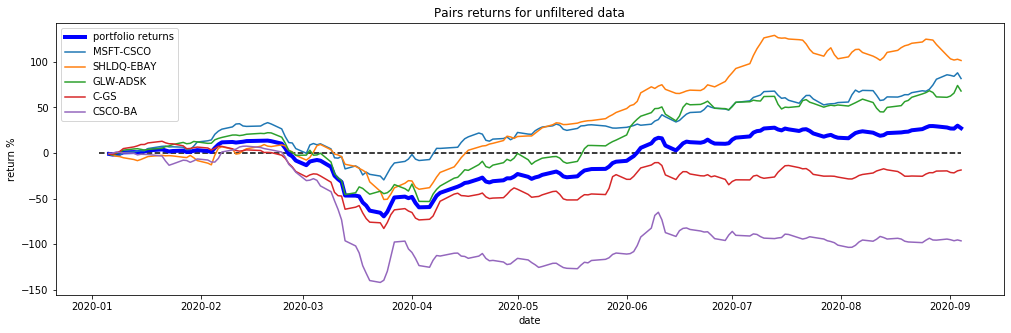

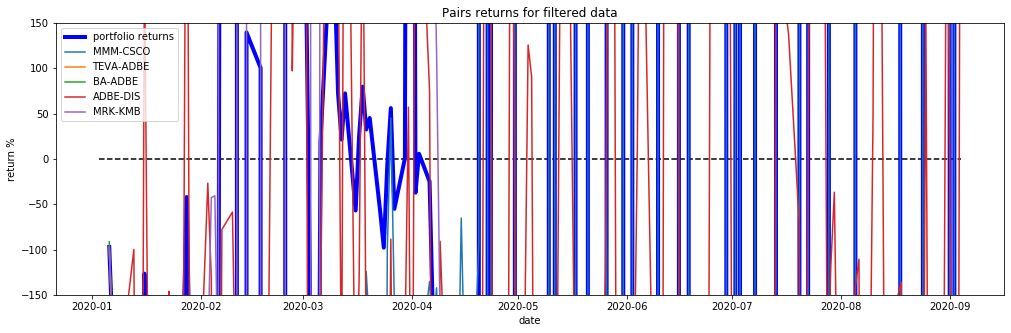

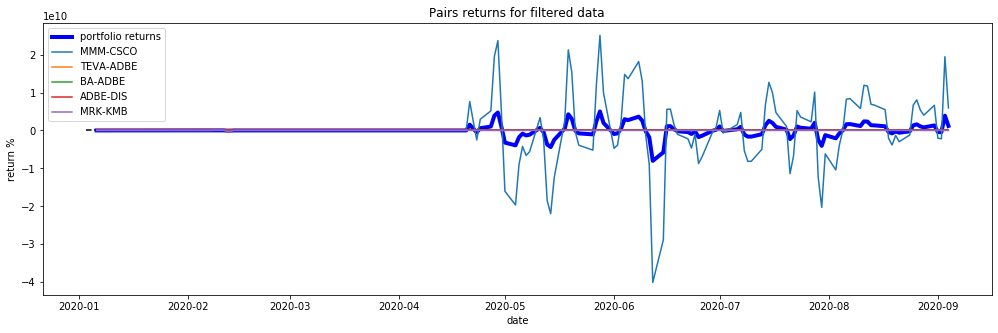

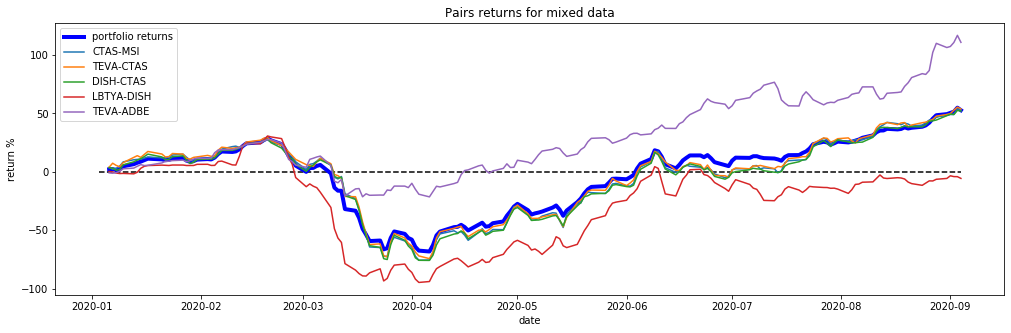

In [855]:
plot_returns(raw_returns, 'unfiltered data')
plot_returns(filt_returns, 'filtered data', 'filter')
plot_returns(filt_returns, 'filtered data')
plot_returns(mixed_returns, 'mixed data')

### Backtesting
In this section, some ratios and statistics for selected portfolios are shown.

In [834]:
total_capital = 500000*len(raw_chosen_pairs) #assume we cannot invest more than 100 000$ per trade, and it is 20% of capital. So capital per equity is
# 500 000$

#### Cumulative returns

In [835]:
def view_cum_returns(returns):
    """Calculate cumulative returns"""
    for ret in returns:
        r = ret.rolling(2).sum()[-1:]
        print('cumulative return for {} is {}%'.format(ret.name, round(r[0])))
    port_ret = sum(returns) / len(returns)
    port_ret_cum = port_ret.rolling(2).sum()[-1:]
    print('cumulative return for portfolio is {}%'.format(round(port_ret_cum[0])))

In [836]:
print('For unfiltered data')
view_cum_returns(raw_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered data')
view_cum_returns(filt_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For mixed data')
view_cum_returns(mixed_returns)

For unfiltered data
cumulative return for MSFT-CSCO is 82.0%
cumulative return for SHLDQ-EBAY is 101.0%
cumulative return for GLW-ADSK is 68.0%
cumulative return for C-GS is -19.0%
cumulative return for CSCO-BA is -96.0%
cumulative return for portfolio is 27.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered data
cumulative return for MMM-CSCO is 5947095638.0%
cumulative return for TEVA-ADBE is -193.0%
cumulative return for BA-ADBE is -194.0%
cumulative return for ADBE-DIS is 772.0%
cumulative return for MRK-KMB is -200.0%
cumulative return for portfolio is 1189419165.0%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For mixed data
cumulative return for CTAS-MSI is 48.0%
cumulative return for TEVA-CTAS is 48.0%
cumulative return for DISH-CTAS is 48.0%
cumulative return for LBTYA-DISH is -6.0%
cumulative return for TEVA-ADBE is 111.0%
cumulative return for portfolio is 50.0%


#### Sharpe ratio
To calculate it we neeed to obtain data on risk-free asset (13 week Treasury bill) and market index return (S&P 500).

In [837]:
size = len(raw_returns[0])
risk_free = yf.download('^IRX', start = "2020-01-02", end = "2020-09-05")['Adj Close'][-size:]
market_idx = yf.download('^GSPC', start = "2020-01-01", end = "2020-09-05")['Adj Close'].pct_change()[1:][-size:] * 100
risk_free.index = risk_free.index.to_period(freq='d')
market_idx.index = market_idx.index.to_period(freq='d')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [838]:
def sharpe(port_returns):
    """Calculates Sharpe ratio"""
    interest_adj = (1 + risk_free)**(1/252) - 1 #since we are given annual rates
    for p in port_returns:
        excess_return = p - interest_adj
        sharpe = excess_return.mean() / excess_return.std()
        print('Sharpe ratio for {} is {}'.format(p.name, round(sharpe, 2)))
    all_returns = sum(port_returns) / len(port_returns)
    all_ex_ret = all_returns - interest_adj
    sharpe_p = all_ex_ret.mean() / all_ex_ret.std()
    print('Sharpe ratio for portfolio is {}'.format(round(sharpe_p, 2)))

In [858]:
print('For unfiltered data')
sharpe(raw_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered data')
sharpe(filt_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For mixed data')
sharpe(mixed_returns)

For unfiltered data
Sharpe ratio for MSFT-CSCO is 1.05
Sharpe ratio for SHLDQ-EBAY is 0.76
Sharpe ratio for GLW-ADSK is 0.49
Sharpe ratio for C-GS is -1.19
Sharpe ratio for CSCO-BA is -1.74
Sharpe ratio for portfolio is -0.14
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered data
Sharpe ratio for MMM-CSCO is 0.03
Sharpe ratio for TEVA-ADBE is -12.69
Sharpe ratio for BA-ADBE is -12.3
Sharpe ratio for ADBE-DIS is -0.16
Sharpe ratio for MRK-KMB is -0.05
Sharpe ratio for portfolio is 0.03
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For mixed data
Sharpe ratio for CTAS-MSI is -0.09
Sharpe ratio for TEVA-CTAS is -0.06
Sharpe ratio for DISH-CTAS is -0.13
Sharpe ratio for LBTYA-DISH is -0.77
Sharpe ratio for TEVA-ADBE is 0.87
Sharpe ratio for portfolio is -0.04


#### Beta

In [804]:
from sklearn.linear_model import LinearRegression
def beta(results):
    """Calculates beta"""
    portfolio_beta = 0
    for i in results:
        capm = LinearRegression(fit_intercept = True).fit(np.array(market_idx).reshape(-1, 1), np.array(i).reshape(-1, 1))
        beta = capm.coef_[0][0]
        print('beta for {} pair is {}'.format(i.name, round(beta, 2)))
        portfolio_beta += beta
    portfolio_beta = portfolio_beta / len(results)
    print('portfolio beta is {}'.format(round(portfolio_beta, 2)))

In [840]:
print('For unfiltered data')
beta(raw_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered data')
beta(filt_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For mixed data')
beta(mixed_returns)

For unfiltered data
beta for MSFT-CSCO pair is -0.23
beta for SHLDQ-EBAY pair is 0.07
beta for GLW-ADSK pair is -0.3
beta for C-GS pair is -0.56
beta for CSCO-BA pair is -1.09
portfolio beta is -0.42
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered data
beta for MMM-CSCO pair is -14001491.65
beta for TEVA-ADBE pair is -0.12
beta for BA-ADBE pair is -0.03
beta for ADBE-DIS pair is 40.8
beta for MRK-KMB pair is -73670.62
portfolio beta is -2815024.33
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For mixed data
beta for CTAS-MSI pair is -0.85
beta for TEVA-CTAS pair is -0.85
beta for DISH-CTAS pair is -0.85
beta for LBTYA-DISH pair is -0.7
beta for TEVA-ADBE pair is -0.29
portfolio beta is -0.71


#### Maximum drawdown

In [806]:
def max_drawdown(val, allocated_capital):
    """Calculates maximum drawdown"""
    max_ = max(val)
    max_idx = list(val).index(max_)
    if max_idx != len(val) -1:
        min_ = min(val[max_idx + 1:])
    else:
        min_ = min(val)
    return (max_ - min_) * 100 / allocated_capital

In [807]:
def daily_drawdown(port_value, allocated_capital):
    """Calculates daily drawdown"""
    sep_drawdowns = []
    for port in port_value:
        day_drawdown = port.diff().dropna()
        day_drawdown = day_drawdown * 100 / allocated_capital
        sep_drawdowns.append(day_drawdown)
        print('maximum daily drawdown for {} is {}%'.format(day_drawdown.name, round(max(day_drawdown), 2)))
    portfolio_drawdown = sum(port_value).diff().dropna() * 100 / (allocated_capital * len(port_value))
    print('maximum daily drawdown for portfolio is {}%'.format(round(max(portfolio_drawdown), 2)))
    return sep_drawdowns, portfolio_drawdown

def week_mdd(port, allocated_capital):
    """Calculates weekly drawdown"""
    weeks = port.resample('W')
    week_mdd = []
    for w in weeks:
        w_mdd = max_drawdown(w[1], allocated_capital)
        week_mdd.append(w_mdd)
    return max(week_mdd)


def weekly_drawdown(port_value, allocated_capital):
    sep_drawdowns = []
    for port in port_value:
        w_mdd = week_mdd(port, allocated_capital)
        sep_drawdowns.append(w_mdd)
        print('maximum weekly drawdown for {} is {}%'.format(port.name, round(w_mdd, 2)))
    all_port = sum(port_value)
    portfolio_drawdown  = week_mdd(all_port, allocated_capital * len(port_value))
    print('maximum weekly drawdown for portfolio is {}%'.format(round(portfolio_drawdown, 2)))
    return sep_drawdowns, portfolio_drawdown

In [808]:
print('For unfiltered data')
raw_day_mdd_sep, raw_day_mdd_all = daily_drawdown(raw_port_value, total_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
raw_week_mdd_sep, raw_week_mdd_all = weekly_drawdown(raw_port_value, total_capital)

For unfiltered data
maximum daily drawdown for MSFT-CSCO is 0.49%
maximum daily drawdown for SHLDQ-EBAY is 0.33%
maximum daily drawdown for GLW-ADSK is 0.47%
maximum daily drawdown for C-GS is 0.45%
maximum daily drawdown for CSCO-BA is 0.38%
maximum daily drawdown for portfolio is 0.34%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
maximum weekly drawdown for MSFT-CSCO is 0.58%
maximum weekly drawdown for SHLDQ-EBAY is 0.54%
maximum weekly drawdown for GLW-ADSK is 0.8%
maximum weekly drawdown for C-GS is 0.72%
maximum weekly drawdown for CSCO-BA is 1.29%
maximum weekly drawdown for portfolio is 0.75%


In [809]:
print('For filtered data')
filt_day_mdd_sep, filt_day_mdd_all = daily_drawdown(filt_port_value, total_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
filt_week_mdd_sep, filt_week_mdd_all = weekly_drawdown(filt_port_value, total_capital)

For filtered data
maximum daily drawdown for MMM-CSCO is 1343868129.42%
maximum daily drawdown for TEVA-ADBE is 0.0%
maximum daily drawdown for BA-ADBE is 0.0%
maximum daily drawdown for ADBE-DIS is 127.09%
maximum daily drawdown for MRK-KMB is 9934607.76%
maximum daily drawdown for portfolio is 268773605.38%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
maximum weekly drawdown for MMM-CSCO is 1816766099.22%
maximum weekly drawdown for TEVA-ADBE is 0.0%
maximum weekly drawdown for BA-ADBE is 0.0%
maximum weekly drawdown for ADBE-DIS is 127.09%
maximum weekly drawdown for MRK-KMB is 13501852.74%
maximum weekly drawdown for portfolio is 363353199.9%


In [844]:
print('For mixed data')
mixed_day_mdd_sep, mixed_day_mdd_all = daily_drawdown(mixed_port_value, total_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
mixed_week_mdd_sep, mixed_week_mdd_all = weekly_drawdown(mixed_port_value, total_capital)

For mixed data
maximum daily drawdown for CTAS-MSI is 0.43%
maximum daily drawdown for TEVA-CTAS is 0.43%
maximum daily drawdown for DISH-CTAS is 0.43%
maximum daily drawdown for LBTYA-DISH is 0.35%
maximum daily drawdown for TEVA-ADBE is 0.6%
maximum daily drawdown for portfolio is 0.32%
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
maximum weekly drawdown for CTAS-MSI is 0.97%
maximum weekly drawdown for TEVA-CTAS is 0.97%
maximum weekly drawdown for DISH-CTAS is 0.97%
maximum weekly drawdown for LBTYA-DISH is 1.05%
maximum weekly drawdown for TEVA-ADBE is 0.62%
maximum weekly drawdown for portfolio is 0.74%


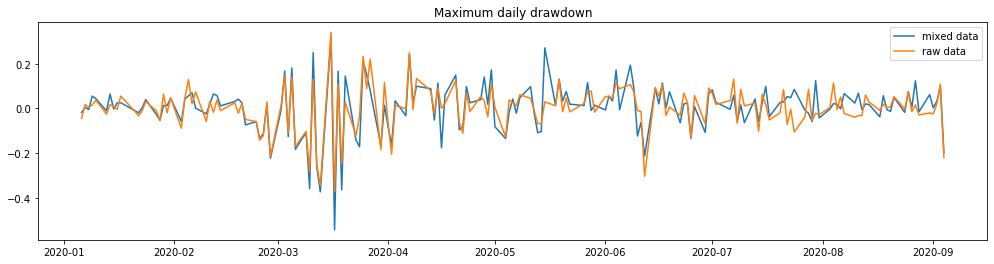

In [862]:
plt.figure(figsize = (17,4))
plt.plot(mixed_day_mdd_all.index.to_timestamp(), mixed_day_mdd_all, label = 'mixed data')
plt.plot(raw_day_mdd_all.index.to_timestamp(), raw_day_mdd_all, label = 'raw data')
plt.legend()
plt.title('Maximum daily drawdown');

#### Accumulated return to maximum drawdown

In [872]:
def return_to_drawdown(port_value, port_returns, allocated_capital):
    """Calculates accumulated return to drawdown ratio"""
    for num, port in enumerate(port_value):
        mdd = max_drawdown(port, allocated_capital)
        cum_ret = port_returns[num].rolling(2).sum()[-1:]
        print('accumulated return to maximum drawdown for {} is {}'.format(port.name, round((cum_ret / mdd)[0],2)))

    port_mdd = max_drawdown(sum(raw_port_value), allocated_capital * len(port_value))
    port_returns = sum(port_returns) / len(port_returns)
    port_cum_ret = port_returns.rolling(2).sum()[-1:] 
    print('accumulated return to maximum drawdown for portfolio is {}'.format(round((port_cum_ret / port_mdd)[0],2)))

In [873]:
print('For unfiltered data')
return_to_drawdown(raw_port_value, raw_returns, total_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered data')
return_to_drawdown(filt_port_value, filt_returns, total_capital)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For mixed data')
return_to_drawdown(mixed_port_value, mixed_returns, total_capital)

For unfiltered data
accumulated return to maximum drawdown for MSFT-CSCO is 226.47
accumulated return to maximum drawdown for SHLDQ-EBAY is 153.26
accumulated return to maximum drawdown for GLW-ADSK is 165.51
accumulated return to maximum drawdown for C-GS is -9.6
accumulated return to maximum drawdown for CSCO-BA is -31.9
accumulated return to maximum drawdown for portfolio is 123.36
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered data
accumulated return to maximum drawdown for MMM-CSCO is 3.05
accumulated return to maximum drawdown for TEVA-ADBE is -48.28
accumulated return to maximum drawdown for BA-ADBE is -48.41
accumulated return to maximum drawdown for ADBE-DIS is 4.35
accumulated return to maximum drawdown for MRK-KMB is -0.0
accumulated return to maximum drawdown for portfolio is 5405213094.37
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For mixed data
accumulated return to maximum drawdown for CTAS-MSI is 306.24
ac

#### 1-day VaR and Expected Shortfall
Var is calculated with D-Vine copula and Peak Over Threshold method

In [787]:

import scipy.stats as ss
from copulas.multivariate import VineCopula

def VaR(raw_returns, q, alpha, mode = 'none'):
    """Calculates VaR with implementation of Peak Over Threshold and Vine copula"""
    df = 8 #since there are 8 parameters
    arr = np.full((len(raw_returns[0]) - 1,len(raw_returns)), None)
    pareto_params_l = []
    stud_params = []
    pareto_params_r = []
    means = []
    variances = []
    for nn, rr in enumerate(raw_returns):
        if mode != 'filter':
            model = arma_garch(rr)
            port_ret = np.array(model[0], dtype = 'float64')
            means.append(model[2])
            variances.append(model[1])
        else:
            port_ret = rr
            means.append(rr.mean())
            variances.append(rr.var())
        #left tail
        
        threshold = np.quantile(port_ret, q)
        low_returns = port_ret[port_ret <= threshold]
        pareto = ss.genpareto.fit(-low_returns) #since distribution is defined for right tail only
        pareto_params_l.append(pareto)
        cdf = ss.genpareto.cdf(-low_returns, *pareto)
        arr[:len(cdf), nn] = cdf
        
        #interior - positive and negative
        threshold_r = np.quantile(port_ret, 1 - q) # right tail
        returns_c = port_ret[(threshold < port_ret) & (port_ret < threshold_r)]            
        student = ss.t.fit(returns_c)
        stud_params.append(student)
        cdf_s = ss.t.cdf(returns_c, *student)
        arr[len(cdf):len(cdf)+len(cdf_s), nn] = cdf_s
        
        
        #right tail - positive
        high_returns = port_ret[port_ret >= threshold_r]
        pareto_r = ss.genpareto.fit(high_returns) #since distribution is defined for right tail only
        pareto_params_r.append(pareto_r)
        cdf_r = ss.genpareto.cdf(high_returns, *pareto_r)
        if mode == 'filter':
            arr[len(cdf)+len(cdf_s):, nn] = cdf_r[:-1]
        else:
            arr[len(cdf)+len(cdf_s):, nn] = cdf_r
        
    arr = np.nan_to_num(arr)    
    var_data = pd.DataFrame(arr, dtype = 'float64')
    

    copula = VineCopula('direct')
    copula.fit(var_data)
    copula_samples = copula.sample(300)                                                                                        
    var_returns = np.full(copula_samples.shape, 0, dtype = 'float64')
    
    for c in range(copula_samples.shape[1]):
        
        low_l = copula_samples.iloc[:, c].quantile(q)       
        high_l = copula_samples.iloc[:, c].quantile(1 - q)   
        
        #left tail                                                                                     
        params_l = pareto_params_l[c]
        set_l =  copula_samples.iloc[:, c][copula_samples.iloc[:, c] <= low_l]                                                                                   
        inv_l = ss.genpareto.ppf(set_l, *params_l) # return to standartized residuals
        if mode != 'filter':
            ret_est_l = inv_l * np.sqrt(variances[c]) * (df - 2) / df + means[c]  #since residuals are from Students distribution
        else:
            ret_est_l = inv_l
        var_returns[:len(ret_est_l), c] = -ret_est_l #because we passed them as positive previously
        
        #interior
        params_c = stud_params[c]
        set_c =  copula_samples.iloc[:, c][(low_l < copula_samples.iloc[:, c]) & (copula_samples.iloc[:, c]< high_l)]                                                                                      
        inv_c = ss.t.ppf(set_c, *params_c) 
        if mode != 'filter':
            ret_est_c = inv_c * np.sqrt(variances[c]) * (df - 2) / df + means[c]
        else:
            ret_est_c = inv_c
        var_returns[len(ret_est_l):len(ret_est_l)+len(ret_est_c), c] = ret_est_c   
        
        #right tail
        params_r = pareto_params_r[c]
        set_h =  copula_samples.iloc[:, c][copula_samples.iloc[:, c] >= high_l]                                                                                      
        inv_r = ss.genpareto.ppf(set_h, *params_r) 
        if mode != 'filter':
            ret_est_r = inv_r * np.sqrt(variances[c])*(df - 2) / df + means[c]
        else:
            ret_est_r = inv_r
        var_returns[len(ret_est_l)+len(ret_est_c):, c] = ret_est_r                                                                                        
                                                                                             
                                                                                             
    var_returns = np.nan_to_num(var_returns)
    var_port_ret = np.sum(var_returns, axis = 1) / var_returns.shape[1]
    var = np.quantile(var_port_ret, alpha)
    #print('VaR at {}% level is {}%'.format(alpha, round(var, 2)))
    return var, var_port_ret

def ES(var, var_port_ret):
    """Caculates expected shortfall"""
    shortfall = var_port_ret[var_port_ret < var].mean()
    #print('Expected shortfall is {}%'.format(round(shortfall, 2)))
    return shortfall

In [777]:
def VaR_curve(ret, window, q, alpha, mode = 'none'):
    """Calculates VaR and Expected Shortfall for several days"""
    all_vars = []
    all_es = []
    ind_st = 0
    if window > len(ret[0]):
        window = 100
    ind_end = window
    raw_returns_df = pd.DataFrame(ret, dtype = 'float64').transpose()
    while ind_end <= raw_returns_df.shape[0] - 1:
        data_used = raw_returns_df.iloc[ind_st:ind_end, :]
        data_to_list = []
        for c in raw_returns_df.columns:
            data_to_list.append(raw_returns_df[c])
        v, v_data = VaR(data_to_list, q, alpha, mode)
        es = ES(v, v_data)
        all_vars.append(v)
        all_es.append(es)
        ind_st += 1
        ind_end += 1
    return all_vars, all_es

def plot_VaR_curve(raw_returns, all_vars, all_es):
    plt.figure(figsize = (15,4))
    plt.plot(raw_returns[0].index.to_timestamp()[-len(all_vars):], all_vars, label = '5% VaR')
    plt.plot(raw_returns[0].index.to_timestamp()[-len(all_es):], all_es, label = '5% Expected Shortfall')
    plt.plot(raw_returns[0].index.to_timestamp()[-len(all_es):], (sum(raw_returns) / len(raw_returns))[-len(all_es):], label = 'portfolio return')
    plt.legend()
    plt.title('VaR and Expected Shortfall curves for past {} days'.format(len(all_es) - 1));
    print("Current VaR is {}%".format(round(all_vars[-1:][0], 2)))
    print("Current Expected Shortfall is {}%".format(round(all_es[-1:][0], 2)))

For unfiltered data
Current VaR is -4.74%
Current Expected Shortfall is -5.24%


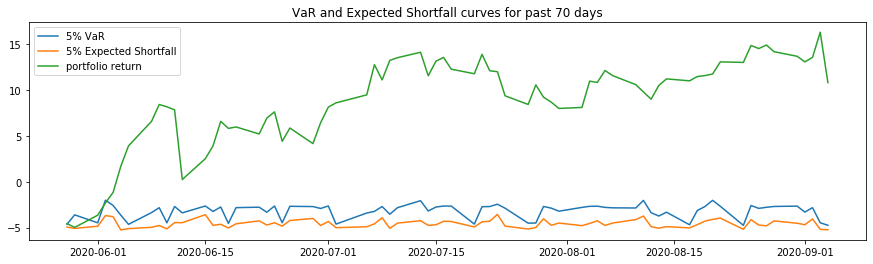

In [846]:
print('For unfiltered data')
raw_var_curve, raw_es_curve = VaR_curve(raw_returns, 200, 0.1, 0.05)
plot_VaR_curve(raw_returns, raw_var_curve, raw_es_curve)

In [774]:
#For filtered data, there are some pairs for which returns are the same all the time. This leads to errors, so I introduce some noise
filt_returns[1] = filt_returns[1] + np.random.rand(len(filt_returns[1]))*5
filt_returns[2] = filt_returns[2] + np.random.rand(len(filt_returns[2]))*5

For filtered data
Current VaR is -163.68%
Current Expected Shortfall is -1.7647500969544796e+23%


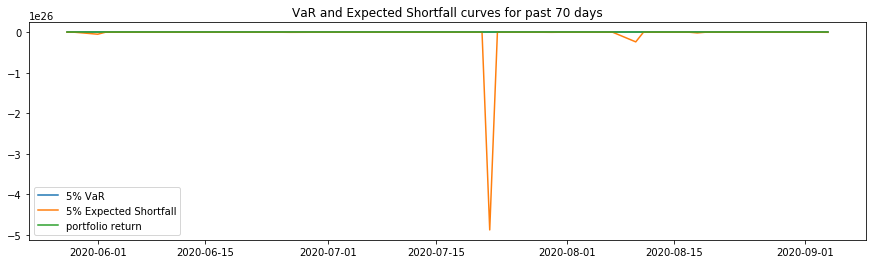

In [876]:
print('For filtered data')
filt_var_curve, filt_es_curve = VaR_curve(filt_returns, 200, 0.1, 0.05, 'filter')
plot_VaR_curve(filt_returns, filt_var_curve, filt_es_curve)

In [851]:
#since for the first three pairs returns are the same since we seem to trade the same asset
mixed_returns[0] = mixed_returns[0] + np.random.rand(len(mixed_returns[0])) * 2
mixed_returns[1] = mixed_returns[1] + np.random.rand(len(mixed_returns[1])) * 3
mixed_returns[2] = mixed_returns[2] + np.random.rand(len(mixed_returns[2])) * 1

For mixed data
Current VaR is -1.97%
Current Expected Shortfall is -3.11%


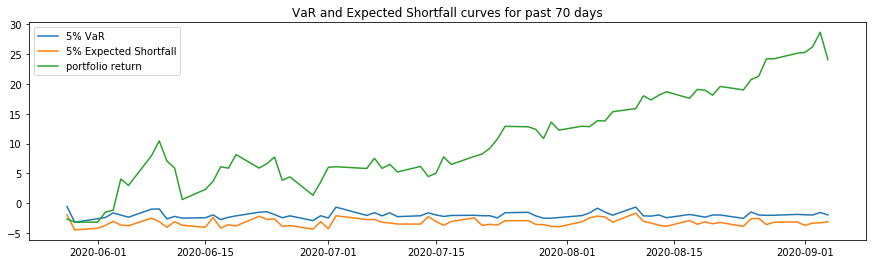

In [852]:
print('For mixed data')
mixed_var_curve, mixed_es_curve = VaR_curve(mixed_returns, 200, 0.1, 0.05)
plot_VaR_curve(mixed_returns, mixed_var_curve, mixed_es_curve)

#### Rachev Ratio

In [853]:
def rachev_ratio(raw_returns, mode = 'none'):
    """Calculates Rachev ratio"""
    var_l, returns_l = VaR(raw_returns, 0.1, 0.01, mode) # left tail
    es_den = ES(var_l, returns_l)
    
    reversed_returns = [] # reverse distribution
    for r in raw_returns:
        reversed_returns.append(-r)
    
    var_r, returns_r = VaR(reversed_returns, 0.1, 0.05, mode) # right tail
    es_num = -ES(var_r, returns_r)

    print('Rachev ratio is {}'.format( - round(es_num / es_den, 2)))

In [854]:
print('For unfiltered data')
rachev_ratio(raw_returns)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For filtered data')
rachev_ratio(filt_returns, 'filter')
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('For mixed data')
rachev_ratio(mixed_returns)

For unfiltered data
Rachev ratio is 0.2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For filtered data
Rachev ratio is 1160050.9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
For mixed data
Rachev ratio is 0.19
